## Studying the performance of Spark

### Students:
- Kawtar LAGHDAF
- Tijana NINKOVIC

In [1]:
import sys
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()
from pyspark import SparkContext
import time
from operator import add
import numpy as np
import pandas as pd

In [2]:
sc = SparkContext("local[3]")
sc.setLogLevel("ERROR")

In [3]:
from pyspark.sql import *
spark = SparkSession(sc)

### Comparing Spark and Pandas

We chose to study Spark DataFrames and compare them to the Pandas library.<br>
A few key differences between Spark DataFrames and Pandas are:
> Pandas data frame is not distributed and Spark DataFrame is. Therefore, when working with large amounts of data, Spark will outperform Pandas.
<br><br>
> Spark DataFrame is resilient and assures fault tolerance, whereas Pandas data frame does not. This is because in case of failure Spark can regenerate the failed result from lineage. Pandas does not have this feature.

Spark's DataFrames are designed for processing large amounts of structured or semi-structured data.
It has the ability to handle petabytes of data. It has support for wide range of data formats and sources.
<br>
DataFrames are distributed which makes them highly available and fault tolerant. They also have lazy evaluation like RDDs, meaning that execution won't start until an action is triggered. DataFrames are also immutable, which means that once created, they cannot be changed. The values can, however, be transformed by applying transformations, just like in RDDs.

First, let's look at how similar these two libraries are by doing some simple analysis in both of them.

In [4]:
machine_events_header = ["timestamp", "machine_ID", "event_type", "platform_ID", "capacity_CPU", "capacity_memory"]
#Loading data set with Spark DataFrame with read.csv
machine_events_spark = spark.read.csv('clusterdata-2011-2/machine_events/part-00000-of-00001.csv.gz')
machine_events_spark = machine_events_spark.withColumnRenamed("_c0", "timestamp")
machine_events_spark = machine_events_spark.withColumnRenamed("_c1", "machine_ID")
machine_events_spark = machine_events_spark.withColumnRenamed("_c2", "event_type")
machine_events_spark = machine_events_spark.withColumnRenamed("_c3", "platform_ID")
machine_events_spark = machine_events_spark.withColumnRenamed("_c4", "capacity_CPU")
machine_events_spark = machine_events_spark.withColumnRenamed("_c5", "capacity_memory")
machine_events_spark.show(5)

+---------+----------+----------+--------------------+------------+---------------+
|timestamp|machine_ID|event_type|         platform_ID|capacity_CPU|capacity_memory|
+---------+----------+----------+--------------------+------------+---------------+
|        0|         5|         0|HofLGzk1Or/8Ildj2...|         0.5|         0.2493|
|        0|         6|         0|HofLGzk1Or/8Ildj2...|         0.5|         0.2493|
|        0|         7|         0|HofLGzk1Or/8Ildj2...|         0.5|         0.2493|
|        0|        10|         0|HofLGzk1Or/8Ildj2...|         0.5|         0.2493|
|        0|        13|         0|HofLGzk1Or/8Ildj2...|         0.5|         0.2493|
+---------+----------+----------+--------------------+------------+---------------+
only showing top 5 rows



In [5]:
#Loading data set with pandas with read_csv
machine_events_pandas = pd.read_csv('clusterdata-2011-2/machine_events/part-00000-of-00001.csv.gz',
                            names = machine_events_header )
machine_events_pandas.head()

,timestamp,machine_ID,event_type,platform_ID,capacity_CPU,capacity_memory
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


In [6]:
#Counting the number of rows with Spark
machine_events_spark.count()

37780

In [14]:
#Counting the number of rows with Pandas
machine_events_pandas.count()

timestamp          37780
machine_ID         37780
event_type         37780
platform_ID        37780
capacity_CPU       37748
capacity_memory    37748
dtype: int64

The results obtainted are slightly different, because Pandas counts for each of the columns separately.

In [46]:
#Filtering with Spark
machine_events_spark.filter(machine_events_spark.capacity_CPU == '0.5').count()

35015

In [42]:
#Filtering with Pandas
machine_events_pandas[machine_events_pandas['capacity_CPU']==0.5].count()

timestamp          35015
machine_ID         35015
event_type         35015
platform_ID        35015
capacity_CPU       35015
capacity_memory    35015
dtype: int64

In [51]:
#Finding correlation with Spark
from pyspark.sql.functions import corr
machine_events_spark.select(corr("capacity_CPU","capacity_memory")).show()

+-----------------------------------+
|corr(capacity_CPU, capacity_memory)|
+-----------------------------------+
|                 0.6848616088591185|
+-----------------------------------+



In [53]:
#Finding correlation with Pandas
machine_events_pandas[['capacity_CPU','capacity_memory']].corr()

,capacity_CPU,capacity_memory
capacity_CPU,1.000000,0.684862
capacity_memory,0.684862,1.000000


After seeing some similar functions of both libraries, we can look at their performance and compare it.
<br>For this we will use **SQL queries** in Spark and equivalent operations in Pandas

In [7]:
from timeit import default_timer as timer
start = timer()
machine_events_spark.registerTempTable('machines_spark')
spark.sql('select * from machines_spark where capacity_memory > 0.4 and capacity_CPU == 0.5').collect()
end = timer()
spark_time_select = end - start
print(spark_time_select)

2.4052718620000633


In [8]:
start = timer()
machine_events_pandas[(machine_events_pandas['capacity_CPU'] == 0.5) & (machine_events_pandas['capacity_memory']>0.4)]
end = timer()
pandas_time_select = end - start
print(pandas_time_select)

0.005688225999847418


Next comparison will be **sorting**

In [9]:
start = timer()
machine_events_spark.registerTempTable('machines_spark')
spark.sql('select * from machines_spark order by capacity_CPU, capacity_memory').collect()
end = timer()
spark_time_sort = end - start
print(spark_time_sort)

2.989183776000118


In [10]:
start = timer()
machine_events_pandas.sort_values(by=['capacity_CPU', 'capacity_memory'])
end = timer()
pandas_time_sort = end - start
print(pandas_time_sort)

0.18032287000005454


Next will be **joining** datasets. We will join machine events with machine attributes.

In [11]:
start = timer()
machine_attributes_spark = spark.read.csv('clusterdata-2011-2/machine_attributes/part-00000-of-00001.csv.gz')
machine_attributes_spark = machine_attributes_spark.withColumnRenamed("_c0", "timestamp")
machine_attributes_spark = machine_attributes_spark.withColumnRenamed("_c1", "machine_ID")
machine_attributes_spark = machine_attributes_spark.withColumnRenamed("_c2", "attribute_name")
machine_attributes_spark = machine_attributes_spark.withColumnRenamed("_c3", "attribute_value")
machine_attributes_spark = machine_attributes_spark.withColumnRenamed("_c4", "attribute_deleted")
end = timer()
print(end-start)

0.3305594270000256


In [12]:
machine_attributes_header = ["timestamp", "machine_ID", "attribute_name", "attribute_value", "attribute_deleted"]
start = timer()
machine_attributes_pandas = pd.read_csv('clusterdata-2011-2/machine_attributes/part-00000-of-00001.csv.gz',
                            names = machine_attributes_header )
end = timer()
print(end-start)

36.92662312900006


In [106]:
start = timer()
machine_events_spark.registerTempTable('machines_spark')
machine_attributes_spark.registerTempTable('machines2_spark')
spark.sql('select * from machines_spark join machines2_spark on machines_spark.timestamp = machines2_spark.timestamp and machines_spark.machine_ID = machines2_spark.machine_ID').collect()
end = timer()
spark_time_join = end - start
print(spark_time_join)

37.521929436999926


In [91]:
start = timer()
pd.merge(machine_events_pandas, machine_attributes_pandas, how = 'left', left_on = ['timestamp', 'machine_ID'], right_on = ['timestamp', 'machine_ID'])
end = timer()
pandas_time_join = end - start
print(pandas_time_join)

4.256840640999144


Final thing we will compare is **grouping**

In [94]:
start = timer()
machine_events_spark.registerTempTable('machines_spark')
spark.sql('select count(*) from machines_spark group by capacity_CPU').collect()
end = timer()
spark_time_group = end - start
print(spark_time_group)

0.9742381450014364


In [97]:
start = timer()
machine_events_pandas.groupby('capacity_CPU').size()
end = timer()
pandas_time_group = end - start
print(pandas_time_group)

0.0020762589992955327


In [111]:
results_df = pd.DataFrame(columns=['Analysis', 'Spark', 'Pandas'])
results_df = results_df.append({'Analysis': 'where clauses', 'Spark': spark_time_select, 'Pandas': pandas_time_select}, ignore_index=True)
results_df = results_df.append({'Analysis': 'sorting', 'Spark': spark_time_sort, 'Pandas': pandas_time_sort}, ignore_index=True)
results_df = results_df.append({'Analysis': 'joining', 'Spark': spark_time_join, 'Pandas': pandas_time_join}, ignore_index=True)
results_df = results_df.append({'Analysis': 'grouping', 'Spark': spark_time_group, 'Pandas': pandas_time_group}, ignore_index=True)
results_df

,Analysis,Spark,Pandas
0,where clauses,0.517818,0.004334
1,sorting,1.117553,0.009236
2,joining,37.521929,4.256841
3,grouping,0.974238,0.002076


<BarContainer object of 4 artists>

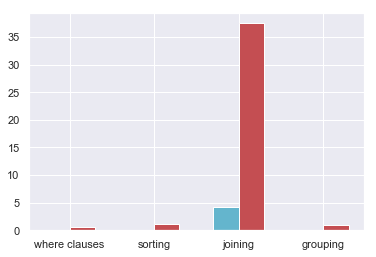

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.bar(results_df['Analysis'], results_df['Spark'], label = "Spark", tick_label = results_df['Analysis'], width=0.3, align='edge', color='r')
plt.bar(results_df['Analysis'], results_df['Pandas'], label = "Pandas", tick_label = results_df['Analysis'], width=-0.3, align='edge', color='c')

Now that we have all our results represented in a table and graphically, we can analyze them properly and draw conslusions. For these analysis we used very small data sets and we can see that in all of the analysis Pandas outperformed Spark. We conclude that for smaller datasets it is definitely better to use Pandas, because Spark's complexity slowed it down.

Next, we will try to repeat these analysis, but with a bigger data set, where Spark is expected to perform better.